# Introduction to Machine Learning, UZH 2018, Group Project
### Group 2: Barbara Capl, Mathias Lüthi, Pamela Matias, Stefanie Rentsch
##       
# 3. Support Vector Machines (SVM)

###   
In this section we use the feature matrices and response vectors with features selected in chapter 2. 


In [1]:
# hide unnecessary warnings ("depreciation" of packages etc.)
import warnings
warnings.filterwarnings('ignore')

# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
plt.style.use('seaborn-whitegrid')

## 3.0. SETTINGS

### (1) Choose the Dataset Version you want

##### Whole Feature Matrix (Features not pre-selected)
VERSION = 1; Feature Matrix with only ratios                                  
VERSION = 2;  Feature Matrix with ratios + saisonality + other market data

##### Reduced Feature Matrix (Features pre-selected)
VERSION = 1.1; Reduced Feature Matrix with only ratios-> best dataset for section 3.3                                  
VERSION = 2.1;  Reduced Feature Matrix with ratios + saisonality + other market data-> best dataset for section 3.2



In [2]:
### Chose which dataset version you want the selection of features and the prediction to be based on 
VERSION = 1.1
"""
INSERT NUMBER 1, 2, 1.1 or 2.1
"""



# Defining sel_state variable for easier printing out    
if VERSION == 1:
    sel_version = 'Based on whole original Dataset with only the Ratios Dataset as predicive Features.'
elif VERSION == 2:
    sel_version = 'Based on whole original Dataset with Ratios + Seasonality + other Market Data as predictive Features.'
elif VERSION == 1.1:
    sel_version = 'Based on reduced Dataset with only the Ratios Dataset as predicive Features.'
elif VERSION == 2.1:
    sel_version = 'Based on reduced Dataset with Ratios + Seasonality + other Market Data as predictive Features.'
else: raise ValueError('VERSION must be either 1, 2, 1.1 or 2.1')

### (2) If you chose VERSION 1.1. or VERSION 2.1:  (Reduced Feature Matrix)                                                                  
### => Choose with which method you want to have the features been pre-selected /reduced

##### You have the choice between:
mySELECTION  = RF ; Features pre-selected with Random Forest Classifier-> best selection for predictions                                                           
mySELECTION = PCA; Features pre-selected with Principal Component Analysis (PCA)                                         

##### By Default;
If VERSION 1 or VERSION 2 was chosen above: SELECTION = none by Default; no features pre-selected. You don't need to define variable mySELECTION.

In [3]:
### Choose whether you want the datasets with features selected with RF or PCA or the original file
mySELECTION = 'RF'
"""
INSERT WISHED METHOD 'RF', 'PCA'
"""



# This is the control loop. If something has been chosen wrong, it returns an error with explanation.
if VERSION == 1 or VERSION == 2:
    SELECTION = 'none'
elif VERSION == 1.1 or VERSION == 2.1:
    SELECTION = mySELECTION
    if mySELECTION is not 'RF' and mySELECTION is not 'PCA':
        raise ValueError('Because VERSION '+str(VERSION)+' is chosen, mySELECTION must be set as either RF or PCA.')
else: raise ValueError('VERSION must be either 1, 2, 1.1 or 2.1. mySELECTION must be chosen as either RF or PCA.')

# Defining of sel_feat (Selected Feature Selection Method) variable and briefing for later.   
if SELECTION == 'RF':
    sel_feat = 'Random Forest (RF)'
    briefing = ('You chose dataset VERSION '+str(VERSION)+' and SELECTION method '+str(SELECTION)+'.'+'\n'+'Features therefore pre-selected with '+str(sel_feat)+'.')
elif SELECTION == 'PCA':
    sel_feat = 'Principal Component Analysis (PCA)'
    briefing = ('You chose dataset VERSION '+str(VERSION)+' and SELECTION method '+str(SELECTION)+'.'+'\n'+'Features therefore pre-selected with '+str(sel_feat)+'.')
elif SELECTION == 'none':
    sel_feat = 'No Feature Selection Method available.'
    briefing = ('You chose VERSION '+str(VERSION)+'. This Version has no Feature Selection Method because Feature Matrix is whole, not reduced.'+'\n'+'SELECTION is therefore "none" by Default.')
else: raise ValueError('mySELECTION must be chosen as either RF or PCA')
print('You chose SELECTION method '+str(sel_feat)+'.')
#print(sel_feat)

You chose SELECTION method Random Forest (RF).


### (3) SUMMARY OF SETTINGS

In [4]:
print(briefing, '\n')
print('VERSION '+str(VERSION)+' is '+str(sel_version),'\n')
print('You are now done with the Settings. You can run the whole Code now by Default.')

You chose dataset VERSION 1.1 and SELECTION method RF.
Features therefore pre-selected with Random Forest (RF). 

VERSION 1.1 is Based on reduced Dataset with only the Ratios Dataset as predicive Features. 

You are now done with the Settings. You can run the whole Code now by Default.


## 3.1. Preparation

### 3.1.1. Import the Response Vector and the Feature Matrix

In [5]:
### import Data (already splitted to train/test-data and selected features-> bc_randomforest_feature_selection)
if VERSION == 1: 
# features not pre-selected, only ratios
    X = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_datasets/features_ratios_1.csv', sep=',', header=0)
    y = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_datasets/response_1.csv', sep=',', header=0)
elif VERSION == 2: 
# features not pre-selected, ratios + seasonality + market data
    X = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_datasets/features_additional_1.csv', sep=',', header=0)
    y = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_datasets/response_1.csv', sep=',', header=0)
elif VERSION == 1.1: 
# features pre-selected, only ratios
    if SELECTION == 'RF':
        X_train_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/X1_train_f.csv', sep=',', header=0)
        X_test_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/X1_test_f.csv', sep=',', header=0)
        y_train_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/y1_train_f.csv', sep=',', header=0)
        y_test_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/y1_test_f.csv', sep=',', header=0)
    elif SELECTION == 'PCA':
        X_train_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/X1_train_p.csv', sep=',', header=0)
        X_test_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/X1_test_p.csv', sep=',', header=0)
        y_train_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/y1_train_p.csv', sep=',', header=0)
        y_test_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/y1_test_p.csv', sep=',', header=0)
elif VERSION == 2.1: 
# features pre-selected, ratios + seasonality + market data
    if SELECTION == 'RF':
        X_train_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/X2_train_f.csv', sep=',', header=0)
        X_test_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/X2_test_f.csv', sep=',', header=0)
        y_train_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/y2_train_f.csv', sep=',', header=0)
        y_test_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/y2_test_f.csv', sep=',', header=0)
    elif SELECTION == 'PCA':
        X_train_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/X2_train_p.csv', sep=',', header=0)
        X_test_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/X2_test_p.csv', sep=',', header=0)
        y_train_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/y2_train_p.csv', sep=',', header=0)
        y_test_s = pd.read_csv('Q:/UZH/FS18/Machine Learning/Projekt/Data/generated_splits/y2_test_p.csv', sep=',', header=0)
else: raise ValueError('VERSION value must be either 1, 2, 1.1 or 2.1, mySELECTION must be chosen as either RF or PCA.')
    
    
#display(X_test_s.shape)

#### Train-Test-split for whole original files. Automatically executed only if VERSION = 1 or 2.

In [6]:
# For VERSION == 1 or 2 -> train-test-split for the importet sets must be done
if VERSION == 1 or VERSION == 2:
    # import package imputer
    from sklearn.preprocessing import Imputer
    # # Train/test split, into 20% test size and 80% train size because it is a relatively small dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Use a median fill for train
    imp = Imputer(missing_values=np.nan, strategy = 'median' , axis=0)
    imputed_dataset = pd.DataFrame(imp.fit_transform(X_train))
    imputed_dataset.columns = X_train.columns
    imputed_dataset.index = X_train.index
    X_train = imputed_dataset

    # Use a median fill for the test set
    imputed_dataset = pd.DataFrame(imp.fit_transform(X_test))
    imputed_dataset.columns = X_test.columns
    imputed_dataset.index = X_test.index
    X_test = imputed_dataset

    # Extract the feature labels
    feature_labels = list(X)
    print('Type of feature_labels = ' + str(type(feature_labels)), '\n')

else: print('No Train/Test split needed for chosen VERSION '+str(VERSION)+
            '. Loaded Datasets were already pre-splitted and imputed in'+'\n'+'Feature Selection (Chapter 2).')
#display(X_train_s.shape)
#display(X_test_s.shape)
    


No Train/Test split needed for chosen VERSION 1.1. Loaded Datasets were already pre-splitted and imputed in
Feature Selection (Chapter 2).


### 3.1.2. Print out Shape and Form of Feature Matrix and Response Vector

### Train Set

In [7]:
# print status
print('Features Selected with ' + str(sel_feat)+'.')
print('Version ' + str(VERSION) + '; ' + str(sel_version), '\n')

# print properties and head
if VERSION == 1 or VERSION == 2:
    print('Shape (rows, columns) of Feature Matrix X (Train) ' + '= ' + str(X_train.shape)+'\n')
    print('Feature Matrix X (Train) with no Feature pre-Selection:')
    display(X_train[0:3])
    print("")
    print('Response Vector y (Train) after no Feature pre-Selection:')
    display(y_train[0:3])
    print("")
else:
    print('Shape (rows, columns) of Feature Matrix X (Train) ' + '= ' + str(X_train_s.shape), '\n')
    print('Feature Matrix X (Train) with Selected Features:'+'\n')
    display(X_train_s[0:3])
    print("")
    print('Response Vector y (Train) after Feature Selection:')
    display(y_train_s[0:3])

Features Selected with Random Forest (RF).
Version 1.1; Based on reduced Dataset with only the Ratios Dataset as predicive Features. 

Shape (rows, columns) of Feature Matrix X (Train) = (2836, 20) 

Feature Matrix X (Train) with Selected Features:



,pe_op_dil,pe_op_basic,CAPEI,pe_exi,pcf,divyield,bm,PEG_ltgforward,ptb,pe_inc,PEG_1yrforward,evm,ps,fcf_ocf,invt_act,at_turn,pretret_noa,gpm,dpr,PEG_trailing
0,15.633,15.468,20.773,18.484,9.957,0.0354,0.547,5.963,1.811,18.484,13.678,10.644,3.703,0.932,0.108,0.291,0.332,0.843,0.623,1.181
1,17.296,17.203,25.089,39.232,8.509,0.0398,0.461,5.702,2.189,39.232,1.521,9.246,0.689,0.441,0.368,0.815,0.146,0.201,2.175,0.668
2,9.209,9.135,12.337,13.062,1.993,0.0268,0.911,2.248,1.076,13.062,0.380,12.474,2.034,1.000,0.152,0.044,0.357,0.906,0.337,3.048



Response Vector y (Train) after Feature Selection:


,0
0,0
1,1
2,0


### Test Set

In [8]:
# print status
print('Features Selected with ' + str(sel_feat))
print('Version ' + str(VERSION) + '; ' + str(sel_version),'\n')

# print properties and head
if VERSION == 1 or VERSION == 2:
    print('Shape (rows, columns) of Feature Matrix X (Test) ' + '= ' + str(X_test.shape)+'\n')
    print('Feature Matrix X (Test) with no Feature pre-Selection:')
    display(X_test[0:3])
    print("")
    print('Response Vector y (Test) after no Feature pre-Selection:')
    display(y_test[0:3])
    print("")
else:
    print('Shape (rows, columns) of Feature Matrix X (Test) ' + '= ' + str(X_test_s.shape)+'\n')
    print('Feature Matrix X (Test) with Selected Features:')
    display(X_test_s[0:3])
    print("")
    print('Response Vector y (Test) after Feature Selection:')
    display(y_test_s[0:3])

Features Selected with Random Forest (RF)
Version 1.1; Based on reduced Dataset with only the Ratios Dataset as predicive Features. 

Shape (rows, columns) of Feature Matrix X (Test) = (710, 20)

Feature Matrix X (Test) with Selected Features:


,pe_op_dil,pe_op_basic,CAPEI,pe_exi,pcf,divyield,bm,PEG_ltgforward,ptb,pe_inc,PEG_1yrforward,evm,ps,fcf_ocf,invt_act,at_turn,pretret_noa,gpm,dpr,PEG_trailing
0,16.224,16.127,20.983,16.224,10.484,0.0187,0.254,1.330,4.189,16.224,1.414,8.585,3.318,0.863,0.025,0.828,1.148,0.428,0.287,1.022
1,16.489,16.311,21.663,18.555,7.709,0.0122,0.235,1.572,4.281,18.555,1.737,13.619,2.379,0.902,0.157,0.223,0.358,0.279,0.199,1.147
2,9.520,9.520,16.327,15.681,8.490,0.0343,0.513,6.149,2.198,15.550,-0.973,6.716,3.293,0.934,0.078,0.355,0.396,0.903,0.792,1.022



Response Vector y (Test) after Feature Selection:


,0
0,1
1,0
2,1


### Define Variables for further use

In [9]:
if VERSION == 1 or VERSION == 2:
    feature_train = X_train
    feature_test = X_test
    response_train = y_train
    response_test = y_test
if VERSION == 1.1 or VERSION == 2.1:
    feature_train = X_train_s
    feature_test = X_test_s
    response_train = y_train_s
    response_test = y_test_s

##### Info: import Version 2.1 with pre-selection rf for best results in the following lines

## 3.2. Best combination of classifier  & parameters

### Version 2.1 with rf pre-selection and Randomforest classifier:

### 3.2.1. classifier: RandomForest

### classweight: unbalanced

In [11]:
# Import necessary functions
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
# Create RandomForest object
rf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                            max_depth=None, max_features='auto', max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
                            oob_score=False, random_state=10, verbose=0, warm_start=False)
# Run CV (= None) and print results
scores =  cross_val_score(rf1, feature_train, response_train)
print(scores)
print('CV accuracy on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))

[0.65750529 0.66666667 0.68359788]
CV accuracy on train set:  0.669 +/-  0.011


In [12]:
# CV (= None) AUC score on train set
scores = cross_val_score(rf1, feature_train, response_train, scoring = 'roc_auc')
print ('CV  AUC on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))

CV  AUC on train set:  0.710 +/-  0.004


In [13]:
from sklearn.model_selection import cross_validate
# Calculate return
measures = ['accuracy', 'recall', 'roc_auc']
scores = cross_validate(rf1, feature_train, response_train, scoring = measures, n_jobs =2)
scores

{'fit_time': array([0.13887644, 0.15889764, 0.16344452]),
 'score_time': array([0.02042174, 0.02256274, 0.02306175]),
 'test_accuracy': array([0.65750529, 0.66666667, 0.68359788]),
 'test_recall': array([0.74499089, 0.7704918 , 0.79781421]),
 'test_roc_auc': array([0.70921942, 0.70630485, 0.715709  ]),
 'train_accuracy': array([1.        , 0.99947118, 1.        ]),
 'train_recall': array([1.        , 0.99908925, 1.        ]),
 'train_roc_auc': array([1.        , 0.99999943, 1.        ])}

In [14]:
# print scores
print('Train set accuracy: ' ,scores ['train_accuracy'].mean())
print('Validation set scores: ',scores ['test_accuracy'].mean())
print('Test set accuracy : ',rf1.fit(feature_test , response_test).score(feature_test, response_test))

Train set accuracy:  0.9998237264234091
Validation set scores:  0.6692566118922708
Test set accuracy :  1.0


#### Prediction

In [15]:
# define y predicted
y_pred1 = rf1.fit(feature_train, response_train).predict(feature_test)
display(y_pred1[0:20])

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1],
      dtype=int64)

In [16]:
print("")
print('Metrics of Classification with RandomForest (best parameters), classweight = unbalanced:')
print("")
print(metrics.classification_report(response_test, y_pred1))
print("")
print('Confusion Matrix with RandomForest (best parameters), classweight = unbalanced:')
print("")
print(metrics.confusion_matrix(response_test, y_pred1))


Metrics of Classification with RandomForest (best parameters), classweight = unbalanced:

             precision    recall  f1-score   support

          0       0.66      0.58      0.62       305
          1       0.71      0.77      0.74       405

avg / total       0.69      0.69      0.69       710


Confusion Matrix with RandomForest (best parameters), classweight = unbalanced:

[[178 127]
 [ 93 312]]


#### Plot Confusion Matrix non-normalized

Confusion matrix, without normalization
[[178 127]
 [ 93 312]]


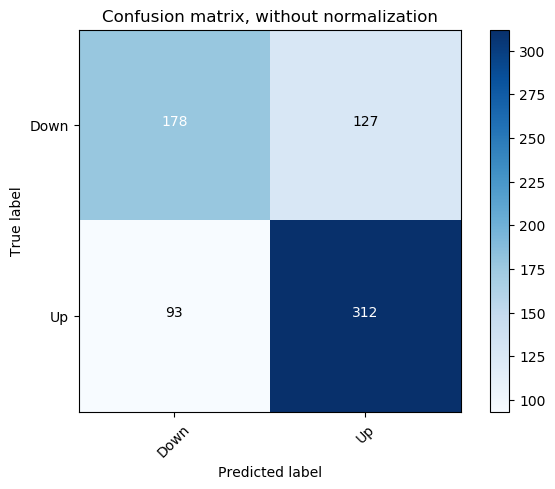

In [17]:
import itertools
plt. style .use('default')

def plot_confusion_matrix(cm, classes,
                          normalize= False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cfm_matrix = metrics.confusion_matrix(response_test , y_pred1)
np.set_printoptions ( precision =2)
# Plot non-normalized confusion matrix
plt.figure ()
plot_confusion_matrix(cfm_matrix, classes =['Down', 'Up'],
                      title = 'Confusion matrix, without normalization')

#### Plot Confusion Matrix normalized

Normalized confusion matrix
[[0.58 0.42]
 [0.23 0.77]]


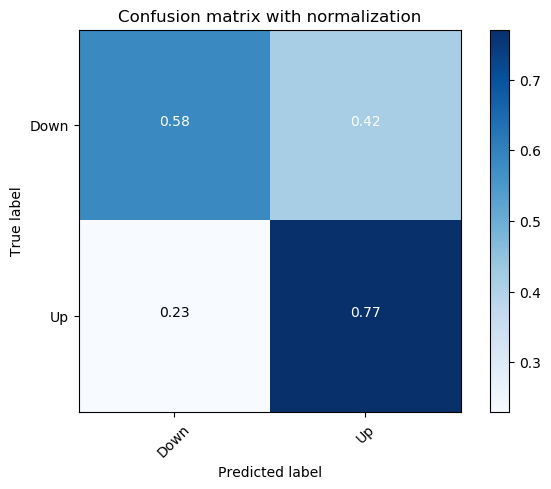

In [18]:
import itertools
plt.style.use('default')

def plot_confusion_matrix(cm, classes,
                          normalize= True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cfm_matrix = metrics.confusion_matrix(response_test , y_pred1)
np.set_printoptions( precision =2)
# plot normalized   confusion   matrix
plt.figure()
plot_confusion_matrix(cfm_matrix, classes =['Down', 'Up'],
                      title = 'Confusion matrix with normalization')

##### different precision scores

In [19]:
print('Precision scores for different input data')
print(55*'_')
print('')
# precision train set
scores = cross_val_score(rf1, feature_train, response_train, scoring = 'precision')
print('CV precision on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# precision test set
scores = cross_val_score(rf1, feature_test, response_test, scoring = 'precision')
print('CV precision on test set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# precision prediction
scores = cross_val_score(rf1, feature_test, y_pred1, scoring = 'precision')
print('CV precision on test prediction set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')

Precision scores for different input data
_______________________________________________________

CV precision on train set:  0.694 +/-  0.004

CV precision on test set:  0.680 +/-  0.035

CV precision on test prediction set:  0.745 +/-  0.017



##### different recall scores

In [21]:
print('Recall scores for different input data')
print(55*'_')
print('')
# recall train set
scores = cross_val_score(rf1, feature_train, response_train, scoring = 'recall')
print('CV recall on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# recall test set
scores = cross_val_score(rf1, feature_test, response_test, scoring = 'recall')
print('CV recall on test set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# recall prediction
scores = cross_val_score(rf1, feature_test, y_pred1, scoring = 'recall')
print('CV recall on test prediction set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')

Recall scores for different input data
_______________________________________________________

CV recall on train set:  0.771 +/-  0.022

CV recall on test set:  0.726 +/-  0.040

CV recall on test prediction set:  0.831 +/-  0.026



#### Plot ROC_AUC curve

##### plot with absolut numbers

In [22]:
# Compute ROC curve and ROC area (AUC) for each class
fpr, tpr, thresholds = metrics.roc_curve(response_test, y_pred1)
roc_auc = metrics.auc(fpr, tpr)

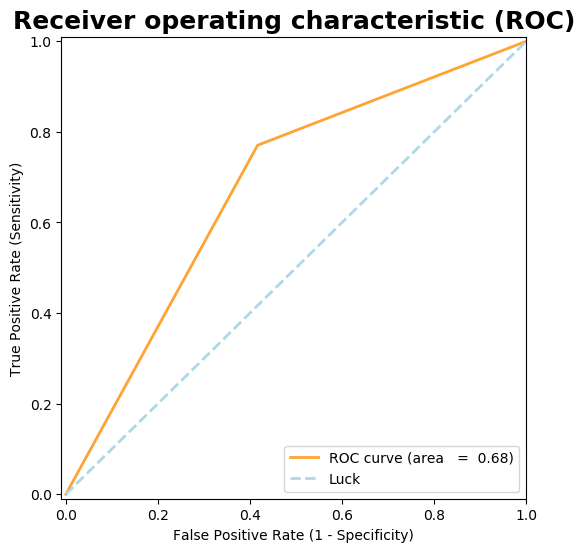

In [23]:
plt.figure(figsize =(6,   6))
plt.plot(fpr, tpr ,   lw=2,
         label = 'ROC curve (area   = {0: 0.2f})'.format(roc_auc), color= 'darkorange', alpha = .8)
plt.plot([0, 1], [0, 1], lw=2, c = 'k', linestyle ='--', label = 'Luck', color = 'lightblue')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic (ROC)', fontweight ='bold', fontsize =18)
plt.legend(loc= "lower right")

##### plot with probabilities

In [24]:
# define probabilities of prediction
probas1_ = rf1.fit(feature_train, response_train).predict_proba(feature_test)

In [25]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = metrics.roc_curve(response_test, probas1_[:, 1])
roc_auc = metrics.auc(fpr , tpr)

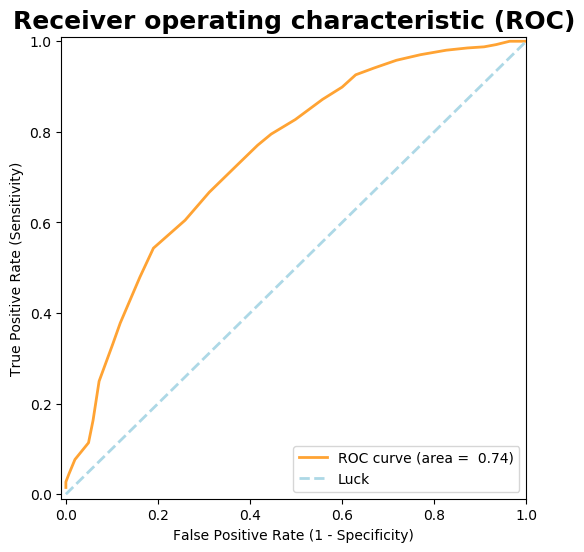

In [26]:
plt.figure(figsize =(6,   6))
plt.plot(fpr, tpr, lw=2,
         label = 'ROC curve (area = {0: 0.2f})'.format(roc_auc), color ='darkorange', alpha = .8)
plt.plot([0, 1], [0, 1], lw=2, c = 'k', linestyle ='--', label = 'Luck', color = 'lightblue')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic (ROC)', fontweight ='bold',   fontsize =18)
plt.legend(loc= "lower right")

### 3.2.2. classifier: RandomForest
### classweight: balanced

In [29]:
# Import necessary functions
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
# Create RandomForest object
rf2 = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
                            max_depth=None, max_features='auto', max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
                            oob_score=False, random_state=10, verbose=0, warm_start=False)
# Run CV (= None) and print results
scores =  cross_val_score(rf2, feature_train, response_train)
print(scores)
print('CV accuracy on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))

[0.66 0.67 0.68]
CV accuracy on train set:  0.668 +/-  0.008


In [30]:
# CV (= None) AUC score on train set
scores = cross_val_score(rf2, feature_train, response_train, scoring = 'roc_auc')
print ('CV  AUC on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))

CV  AUC on train set:  0.709 +/-  0.008


In [31]:
from sklearn.model_selection import cross_validate
# Calculate return
measures = ['accuracy', 'recall', 'roc_auc']
scores = cross_validate(rf2, feature_train, response_train, scoring = measures, n_jobs =2)
scores

{'fit_time': array([0.15, 0.14, 0.14]),
 'score_time': array([0.02, 0.02, 0.02]),
 'test_accuracy': array([0.66, 0.67, 0.68]),
 'test_recall': array([0.76, 0.76, 0.8 ]),
 'test_roc_auc': array([0.7 , 0.71, 0.72]),
 'train_accuracy': array([1., 1., 1.]),
 'train_recall': array([1., 1., 1.]),
 'train_roc_auc': array([1., 1., 1.])}

In [32]:
# print scores
print('Train set accuracy: ' ,scores ['train_accuracy'].mean())
print('Validation set scores: ',scores ['test_accuracy'].mean())
print('Test set accuracy : ',rf2.fit(feature_test , response_test).score(feature_test, response_test))

Train set accuracy:  0.9989422652740121
Validation set scores:  0.6678453042794127
Test set accuracy :  1.0


#### Prediction

In [33]:
# define y predicted
y_pred2 = rf2.fit(feature_train, response_train).predict(feature_test)
display(y_pred2[0:20])

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1],
      dtype=int64)

In [34]:
print("")
print('Metrics of Classification with RandomForest (best parameters), classweight = unbalanced:')
print("")
print(metrics.classification_report(response_test, y_pred2))
print("")
print('Confusion Matrix with RandomForest (best parameters), classweight = unbalanced:')
print("")
print(metrics.confusion_matrix(response_test, y_pred2))


Metrics of Classification with RandomForest (best parameters), classweight = unbalanced:

             precision    recall  f1-score   support

          0       0.66      0.60      0.63       305
          1       0.72      0.77      0.74       405

avg / total       0.69      0.70      0.69       710


Confusion Matrix with RandomForest (best parameters), classweight = unbalanced:

[[182 123]
 [ 92 313]]


#### Plot Confusion Matrix non-normalized

Confusion matrix, without normalization
[[182 123]
 [ 92 313]]


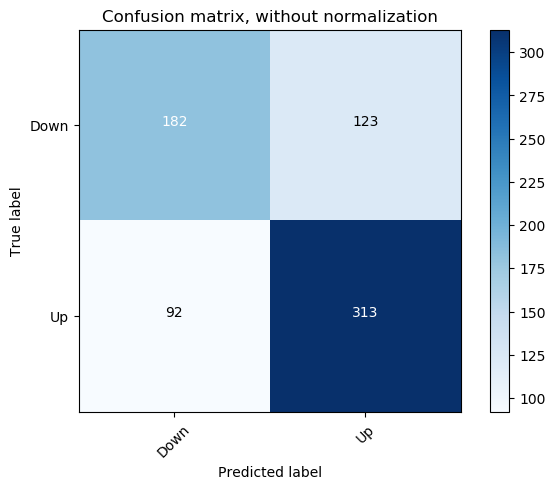

In [35]:
import itertools
plt. style .use('default')

def plot_confusion_matrix(cm, classes,
                          normalize= False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cfm_matrix = metrics.confusion_matrix(response_test , y_pred2)
np.set_printoptions ( precision =2)
# Plot non-normalized confusion matrix
plt.figure ()
plot_confusion_matrix(cfm_matrix, classes =['Down', 'Up'],
                      title = 'Confusion matrix, without normalization')

#### Plot Confusion Matrix normalized

Normalized confusion matrix
[[0.6  0.4 ]
 [0.23 0.77]]


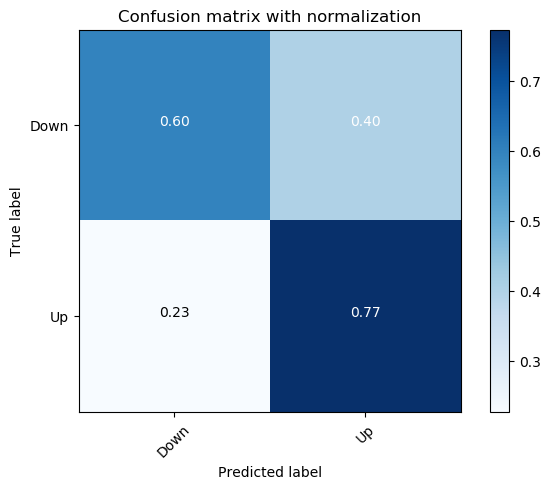

In [36]:
import itertools
plt.style.use('default')

def plot_confusion_matrix(cm, classes,
                          normalize= True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cfm_matrix = metrics.confusion_matrix(response_test , y_pred2)
np.set_printoptions( precision =2)
# plot normalized   confusion   matrix
plt.figure()
plot_confusion_matrix(cfm_matrix, classes =['Down', 'Up'],
                      title = 'Confusion matrix with normalization')

##### different Precision scores

In [37]:
print('Precision scores for different input data')
print(55*'_')
print('')
# precision train set
scores = cross_val_score(rf2, feature_train, response_train, scoring = 'precision')
print('CV precision on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# precision test set
scores = cross_val_score(rf2, feature_test, response_test, scoring = 'precision')
print('CV precision on test set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# precision prediction
scores = cross_val_score(rf2, feature_test, y_pred2, scoring = 'precision')
print('CV precision on test prediction set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')

Precision scores for different input data
_______________________________________________________

CV precision on train set:  0.691 +/-  0.004

CV precision on test set:  0.682 +/-  0.013

CV precision on test prediction set:  0.764 +/-  0.016



##### different Recall scores

In [39]:
print('Recall scores for different input data')
print(55*'_')
print('')
# recall train set
scores = cross_val_score(rf2, feature_train, response_train, scoring = 'recall')
print('CV recall on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# recall test set
scores = cross_val_score(rf2, feature_test, response_test, scoring = 'recall')
print('CV recall on test set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# recall prediction
scores = cross_val_score(rf2, feature_test, y_pred2, scoring = 'recall')
print('CV recall on test prediction set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')

Recall scores for different input data
_______________________________________________________

CV recall on train set:  0.775 +/-  0.016

CV recall on test set:  0.726 +/-  0.006

CV recall on test prediction set:  0.849 +/-  0.025



#### Plot ROC_AUC curve

##### plot with absolut numbers

In [40]:
# Compute ROC curve and ROC area (AUC) for each class
fpr, tpr, thresholds = metrics.roc_curve(response_test, y_pred2)
roc_auc = metrics.auc(fpr, tpr)

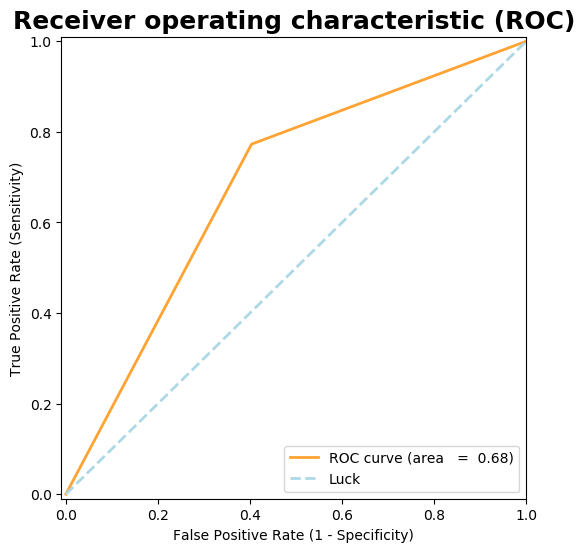

In [41]:
plt.figure(figsize =(6,   6))
plt.plot(fpr, tpr ,   lw=2,
         label = 'ROC curve (area   = {0: 0.2f})'.format(roc_auc), color= 'darkorange', alpha = .8)
plt.plot([0, 1], [0, 1], lw=2, c = 'k', linestyle ='--', label = 'Luck', color = 'lightblue')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic (ROC)', fontweight ='bold', fontsize =18)
plt.legend(loc= "lower right")

##### plot with probabilities

In [42]:
# define probabilities of prediction
probas2_ = rf2.fit(feature_train, response_train).predict_proba(feature_test)

In [43]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = metrics.roc_curve(response_test, probas2_[:, 1])
roc_auc = metrics.auc(fpr , tpr)

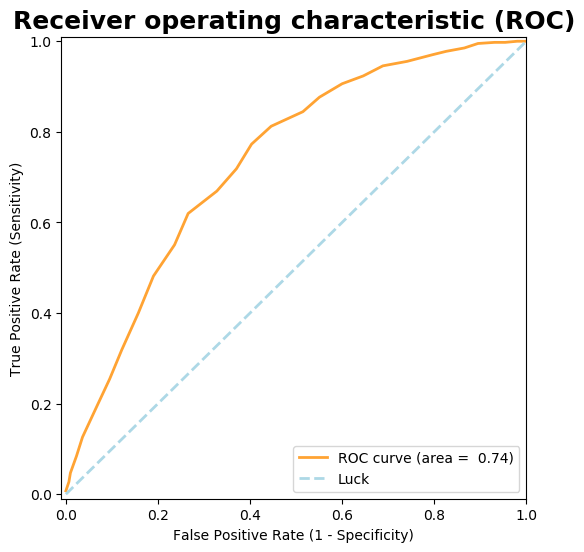

In [44]:
plt.figure(figsize =(6,   6))
plt.plot(fpr, tpr, lw=2,
         label = 'ROC curve (area = {0: 0.2f})'.format(roc_auc), color ='darkorange', alpha = .8)
plt.plot([0, 1], [0, 1], lw=2, c = 'k', linestyle ='--', label = 'Luck', color = 'lightblue')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic (ROC)', fontweight ='bold',   fontsize =18)
plt.legend(loc= "lower right")

##### Info: Kernel restart and import Version 1.1 with pre-selection rf for best result in the following lines

## 3.3. Second Best combination of classifier  & parameters

### Version 1.1 with rf pre-selection and LogisticRegression classifier:

### 3.3.1. classifier: LogisticRegression
### classweight: unbalanced

In [10]:
# Import necessary functions
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
# Create k-Fold CV and LogReg object
kFold = StratifiedKFold(n_splits =5, random_state =0)
logReg1 = LogisticRegression()
# Run CV(= None) and print results
scores =  cross_val_score(logReg1, feature_train, response_train, cv= kFold)
print(scores)
print('CV accuracy on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))

[0.58098592 0.59859155 0.60141093 0.62081129 0.6024735 ]
CV accuracy on train set:  0.601 +/-  0.013


In [11]:
# CV AUC score on train set
scores = cross_val_score(logReg1, feature_train, response_train, cv=kFold , scoring = 'roc_auc')
print ('CV  AUC on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))

CV  AUC on train set:  0.614 +/-  0.021


In [12]:
from sklearn.model_selection import cross_validate
# Calculate return
measures = ['accuracy', 'recall', 'roc_auc']
scores = cross_validate(logReg1, feature_train, response_train, cv=kFold, scoring = measures, n_jobs =2)
scores

{'fit_time': array([0.03657055, 0.04512572, 0.03058386, 0.04010773, 0.04411578]),
 'score_time': array([0.03559661, 0.02005339, 0.00200438, 0.00200605, 0.00200582]),
 'test_accuracy': array([0.58098592, 0.59859155, 0.60141093, 0.62081129, 0.6024735 ]),
 'test_recall': array([0.84545455, 0.84848485, 0.82978723, 0.87234043, 0.86018237]),
 'test_roc_auc': array([0.59051439, 0.63632544, 0.59460806, 0.64050727, 0.60819771]),
 'train_accuracy': array([0.61992945, 0.60802469, 0.60863817, 0.59585721, 0.60792952]),
 'train_recall': array([0.84813971, 0.88003037, 0.83687405, 0.86722307, 0.85660091]),
 'train_roc_auc': array([0.63429296, 0.62203316, 0.63339524, 0.62170481, 0.62956271])}

In [13]:
# print scores
print('Train set accuracy (CV=5): ' ,scores ['train_accuracy'].mean())
print('Validation set scores (CV=5): ',scores ['test_accuracy'].mean())
print('Test set accuracy : ',logReg1.fit(feature_test , response_test).score(feature_test, response_test))

Train set accuracy (CV=5):  0.6080758064900135
Validation set scores (CV=5):  0.600854637048834
Test set accuracy :  0.6338028169014085


#### Prediction

In [15]:
# define y predicted
y_pred3 = logReg1.fit(feature_train, response_train).predict(feature_test)
display(y_pred3[0:20])

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1],
      dtype=int64)

In [16]:
print("")
print('Metrics of Classification with LogisticRegression (random parameters), classweight = unbalanced:')
print("")
print(metrics.classification_report(response_test, y_pred3))
print("")
print('Confusion Matrix with LogisticRegression (random parameters), classweight = unbalanced:')
print("")
print(metrics.confusion_matrix(response_test, y_pred3))


Metrics of Classification with LogisticRegression (random parameters), classweight = unbalanced:

             precision    recall  f1-score   support

          0       0.68      0.31      0.42       305
          1       0.63      0.89      0.74       405

avg / total       0.65      0.64      0.60       710


Confusion Matrix with LogisticRegression (random parameters), classweight = unbalanced:

[[ 94 211]
 [ 45 360]]


#### Plot Confusion matrix non normalized

Confusion matrix, without normalization
[[ 94 211]
 [ 45 360]]


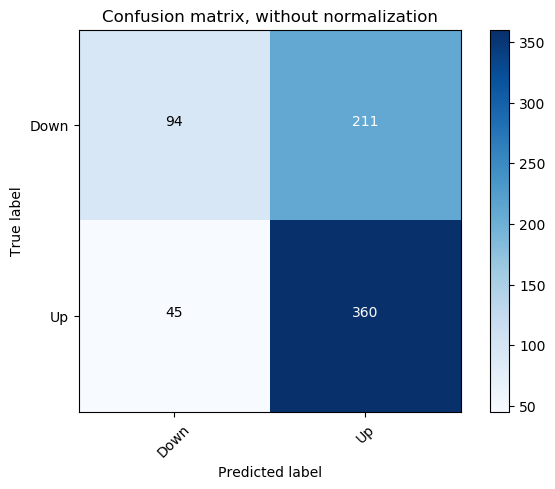

In [17]:
import itertools
plt. style .use('default')

def plot_confusion_matrix(cm, classes,
                          normalize= False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cfm_matrix = metrics.confusion_matrix(response_test , y_pred3)
np.set_printoptions ( precision =2)
# Plot non-normalized confusion matrix
plt.figure ()
plot_confusion_matrix(cfm_matrix, classes =['Down', 'Up'],
                      title = 'Confusion matrix, without normalization')

#### Plot normalized confusion matrix

Normalized confusion matrix
[[0.31 0.69]
 [0.11 0.89]]


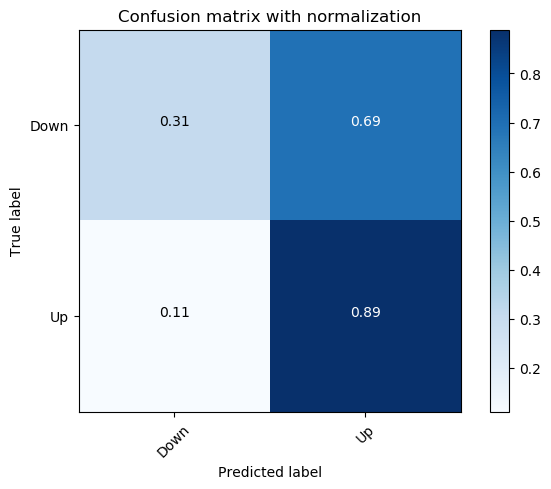

In [18]:
import itertools
plt.style.use('default')

def plot_confusion_matrix(cm, classes,
                          normalize= True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cfm_matrix = metrics.confusion_matrix(response_test , y_pred3)
np.set_printoptions( precision =2)
# plot normalized   confusion   matrix
plt.figure()
plot_confusion_matrix(cfm_matrix, classes =['Down', 'Up'],
                      title = 'Confusion matrix with normalization')

##### different precision scores

In [19]:
print('Precision scores for different input data')
print(55*'_')
print('')
# precision train set
scores = cross_val_score(logReg1, feature_train, response_train, cv=kFold , scoring = 'precision')
print('CV precision on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# precision test set
scores = cross_val_score(logReg1, feature_test, response_test, cv=kFold , scoring = 'precision')
print('CV precision on test set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# precision prediction
scores = cross_val_score(logReg1, feature_test, y_pred3, cv=kFold , scoring = 'precision')
print('CV precision on test prediction set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')

Precision scores for different input data
_______________________________________________________

CV precision on train set:  0.613 +/-  0.008

CV precision on test set:  0.620 +/-  0.012

CV precision on test prediction set:  0.889 +/-  0.015



##### different recall scores

In [20]:
print('Recall scores for different input data')
print(55*'_')
print('')
# recall train set
scores = cross_val_score(logReg1, feature_train, response_train, cv=kFold , scoring = 'recall')
print('CV recall on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# recall test set
scores = cross_val_score(logReg1, feature_test, response_test, cv=kFold , scoring = 'recall')
print('CV recall on test set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# recall prediction
scores = cross_val_score(logReg1, feature_test, y_pred3, cv=kFold , scoring = 'recall')
print('CV recall on test prediction set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')

Recall scores for different input data
_______________________________________________________

CV recall on train set:  0.851 +/-  0.014

CV recall on test set:  0.795 +/-  0.037

CV recall on test prediction set:  0.974 +/-  0.012



#### Plot ROC_AUC curve

##### Plot with absolut numbers

In [21]:
# Compute ROC curve and ROC area (AUC) for each class
fpr, tpr, thresholds = metrics.roc_curve(response_test, y_pred3)
roc_auc = metrics.auc(fpr, tpr)

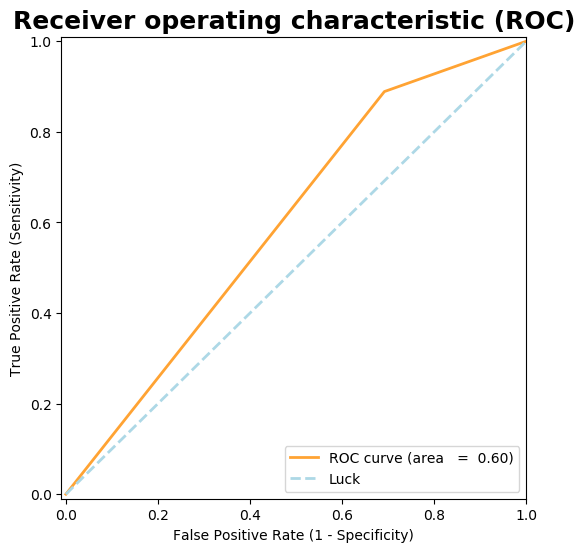

In [22]:
plt.figure(figsize =(6,   6))
plt.plot(fpr, tpr ,   lw=2,
         label = 'ROC curve (area   = {0: 0.2f})'.format(roc_auc), color= 'darkorange', alpha = .8)
plt.plot([0, 1], [0, 1], lw=2, c = 'k', linestyle ='--', label = 'Luck', color = 'lightblue')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic (ROC)', fontweight ='bold', fontsize =18)
plt.legend(loc= "lower right")

##### Plot with probabilities

In [23]:
# define probabilities of prediction
probas3_ = logReg1.fit(feature_train, response_train).predict_proba(feature_test)

In [24]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = metrics.roc_curve(response_test, probas3_[:, 1])
roc_auc = metrics.auc(fpr , tpr)

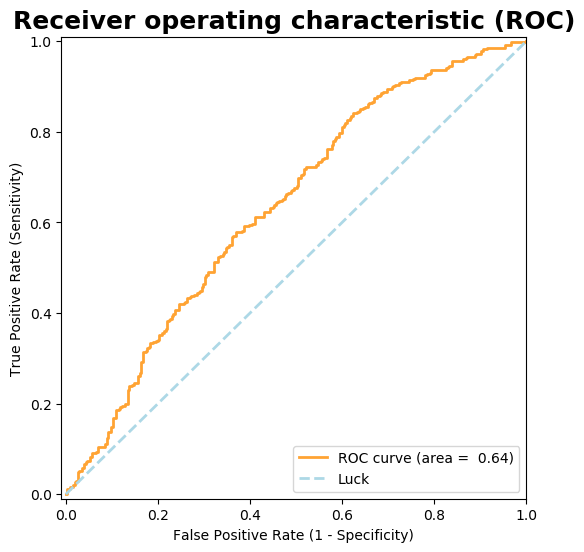

In [25]:
plt.figure(figsize =(6,   6))
plt.plot(fpr, tpr, lw=2,
         label = 'ROC curve (area = {0: 0.2f})'.format(roc_auc), color ='darkorange', alpha = .8)
plt.plot([0, 1], [0, 1], lw=2, c = 'k', linestyle ='--', label = 'Luck', color = 'lightblue')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic (ROC)', fontweight ='bold',   fontsize =18)
plt.legend(loc= "lower right")

### 3.3.2. classifier: LogisticRegression
### classweight: balanced

In [26]:
# Create k-Fold CV and LogReg object
kFold = StratifiedKFold(n_splits =5, random_state =0)
logReg2 = LogisticRegression(class_weight = 'balanced')
# Run CV and print results
scores =  cross_val_score(logReg2, feature_train, response_train, cv= kFold )
print(scores)
print('CV accuracy on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))

[0.56 0.59 0.57 0.61 0.58]
CV accuracy on train set:  0.582 +/-  0.017


In [27]:
scores = cross_val_score(logReg2, feature_train, response_train, cv=kFold , scoring = 'roc_auc')
print ('CV  AUC on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))

CV  AUC on train set:  0.614 +/-  0.021


In [28]:
# Calculate return
measures = ['accuracy', 'recall', 'roc_auc']
scores = cross_validate(logReg2, feature_train, response_train, cv=kFold, scoring = measures, n_jobs =2)
scores

{'fit_time': array([0.04, 0.04, 0.04, 0.04, 0.05]),
 'score_time': array([0.07, 0.03, 0.  , 0.  , 0.  ]),
 'test_accuracy': array([0.56, 0.59, 0.57, 0.61, 0.58]),
 'test_recall': array([0.57, 0.57, 0.52, 0.57, 0.58]),
 'test_roc_auc': array([0.59, 0.64, 0.6 , 0.64, 0.61]),
 'train_accuracy': array([0.6 , 0.58, 0.59, 0.59, 0.59]),
 'train_recall': array([0.57, 0.56, 0.58, 0.57, 0.56]),
 'train_roc_auc': array([0.63, 0.62, 0.63, 0.62, 0.63])}

In [29]:
# print scores
print('Train set accuracy (CV=5): ' ,scores ['train_accuracy'].mean())
print('Validation set scores (CV=5): ',scores ['test_accuracy'].mean())
print('Test set accuracy : ',logReg2.fit(feature_test , response_test).score(feature_test, response_test))

Train set accuracy (CV=5):  0.5900029065467209
Validation set scores (CV=5):  0.5818076060955008
Test set accuracy :  0.6380281690140845


#### Prediction

In [30]:
# define y predicted
y_pred4 = logReg2.fit(feature_train, response_train).predict(feature_test)
display(y_pred4[0:20])

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
      dtype=int64)

In [31]:
print("")
print('Metrics of Classification with LogisticRegression (random parameters), classweight = balanced:')
print("")
print(metrics.classification_report(response_test, y_pred4))
print("")
print('Confusion Matrix with LogisticRegression (random parameters), classweight = balanced:')
print("")
print(metrics.confusion_matrix(response_test, y_pred4))


Metrics of Classification with LogisticRegression (random parameters), classweight = balanced:

             precision    recall  f1-score   support

          0       0.53      0.62      0.57       305
          1       0.67      0.58      0.62       405

avg / total       0.61      0.60      0.60       710


Confusion Matrix with LogisticRegression (random parameters), classweight = balanced:

[[188 117]
 [169 236]]


#### Plot Confusion matrix non normalized

Confusion matrix, without normalization
[[188 117]
 [169 236]]


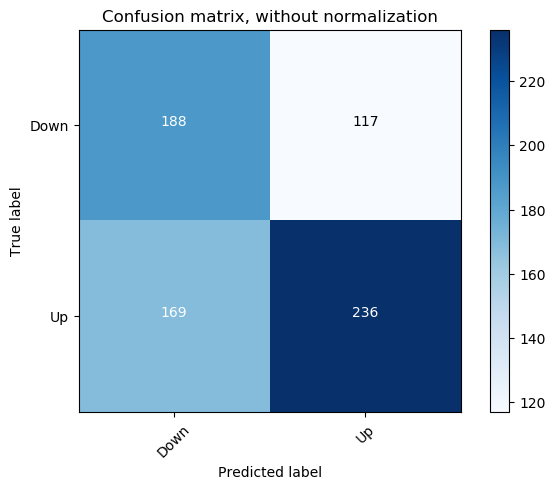

In [32]:
import itertools
plt. style .use('default')

def plot_confusion_matrix(cm, classes,
                          normalize= False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cfm_matrix = metrics.confusion_matrix(response_test , y_pred4)
np.set_printoptions ( precision =2)
# Plot non-normalized confusion matrix
plt.figure ()
plot_confusion_matrix(cfm_matrix, classes =['Down', 'Up'],
                      title = 'Confusion matrix, without normalization')

#### Plot normalized confusion matrix

Normalized confusion matrix
[[0.62 0.38]
 [0.42 0.58]]


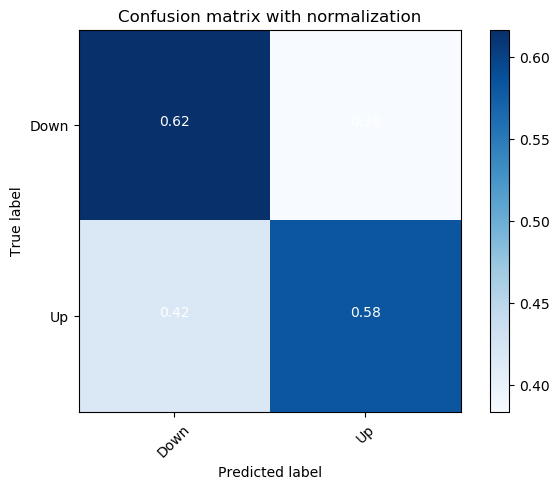

In [33]:
import itertools
plt.style.use('default')

def plot_confusion_matrix(cm, classes,
                          normalize= True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cfm_matrix = metrics.confusion_matrix(response_test , y_pred4)
np.set_printoptions( precision =2)
# plot normalized   confusion   matrix
plt.figure()
plot_confusion_matrix(cfm_matrix, classes =['Down', 'Up'],
                      title = 'Confusion matrix with normalization')

##### different precision scores

In [34]:
print('Precision scores for different input data')
print(55*'_')
print('')
# precision train set
scores = cross_val_score(logReg2, feature_train, response_train, cv=kFold , scoring = 'precision')
print('CV precision on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# precision test set
scores = cross_val_score(logReg2, feature_test, response_test, cv=kFold , scoring = 'precision')
print('CV precision on test set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# precision prediction
scores = cross_val_score(logReg2, feature_test, y_pred4, cv=kFold , scoring = 'precision')
print('CV precision on test prediction set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')

Precision scores for different input data
_______________________________________________________

CV precision on train set:  0.666 +/-  0.021

CV precision on test set:  0.660 +/-  0.042

CV precision on test prediction set:  0.916 +/-  0.022



##### different recall scores

In [35]:
print('Recall scores for different input data')
print(55*'_')
print('')
# recall train set
scores = cross_val_score(logReg2, feature_train, response_train, cv=kFold , scoring = 'recall')
print('CV recall on train set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# recall test set
scores = cross_val_score(logReg2, feature_test, response_test, cv=kFold , scoring = 'recall')
print('CV recall on test set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')
# recall prediction
scores = cross_val_score(logReg2, feature_test, y_pred4, cv=kFold , scoring = 'recall')
print('CV recall on test prediction set: {0: .3f} +/- {1: .3f}'.format(np.mean(scores), np.std(scores)))
print('')

Recall scores for different input data
_______________________________________________________

CV recall on train set:  0.563 +/-  0.020

CV recall on test set:  0.598 +/-  0.071

CV recall on test prediction set:  0.895 +/-  0.034



#### Plot ROC_AUC curve

##### Plot with absolut numbers

In [36]:
 #   Compute   ROC   curve   and   ROC   area   (AUC)   for   each   class
fpr, tpr, thresholds = metrics.roc_curve(response_test, y_pred4)
roc_auc = metrics.auc(fpr, tpr)

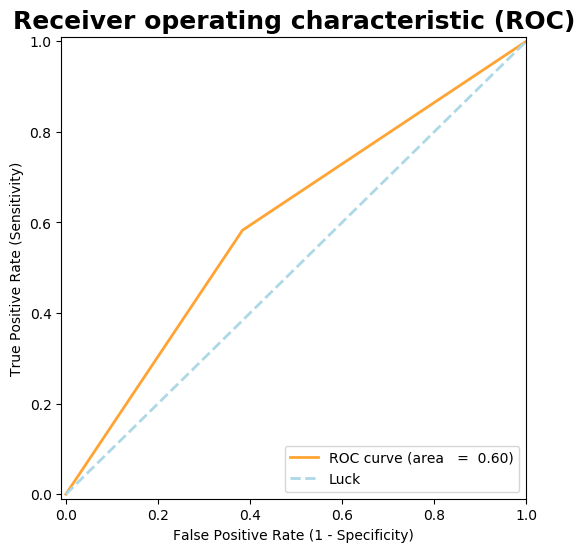

In [37]:
plt.figure(figsize =(6,   6))
plt.plot(fpr, tpr ,   lw=2,
         label = 'ROC curve (area   = {0: 0.2f})'.format(roc_auc), color= 'darkorange', alpha = .8)
plt.plot([0, 1], [0, 1], lw=2, c = 'k',   linestyle ='--', label = 'Luck', color = 'lightblue')
plt.xlim([-0.01, 1.0 ])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic (ROC)', fontweight ='bold',   fontsize =18)
plt.legend(loc= "lower right")

##### Plot with probabilities

In [38]:
# define probabilities of prediction
probas4_ = logReg2.fit(feature_train, response_train).predict_proba(feature_test)

In [39]:
# Compute ROC curve and area the curve
fpr, tpr, thresholds = metrics.roc_curve(response_test, probas4_[:, 1])
roc_auc   =   metrics.auc(fpr , tpr)

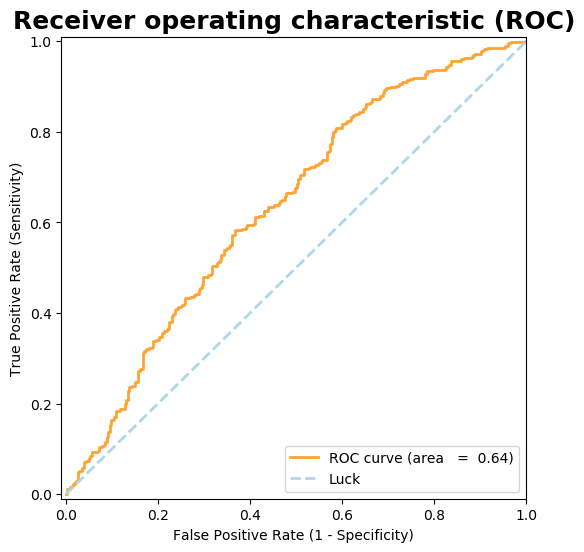

In [40]:
plt. figure (figsize =(6,   6))
plt.plot(fpr, tpr ,   lw=2,
         label = 'ROC curve (area   = {0: 0.2f})'.format(roc_auc), color ='darkorange', alpha = .8)
plt.plot([0, 1], [0, 1], lw=2, c = 'k', linestyle ='--', label = 'Luck', color = 'lightblue')
plt.xlim([-0.01, 1.0 ])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic (ROC)', fontweight ='bold',   fontsize =18)
plt.legend(loc= "lower right")

## Result

In [ ]:
# -> best scores and confusion matrix results with Version 2.1 (rf pre-selection) and a Random Forest classifier balanced
# -> if we run predictions only with reduced dataset, second best output gives Version 1.1 with rf pre-selection and LogisticRegression classifier balanced
# -> original datasets aren't much better than the reduced ones